# Validation Step

Notebook này thực hiện kiểm định và đánh giá chất lượng toàn bộ pipeline mô phỏng rủi ro danh mục đầu tư dựa trên mô hình GARCH, EVT và copula.
Các bước chính gồm:

1. **Rolling VaR backtest:** Kiểm tra khả năng dự báo rủi ro tail của mô hình bằng cách so sánh VaR dự báo với dữ liệu thực tế trên cửa sổ trượt.
2. **Kiểm định Kupiec và Christoffersen:** Đánh giá xác suất và tính độc lập của các vi phạm VaR, xác nhận độ tin cậy của mô hình.
3. **Fit Vinecopula và kiểm tra PIT:** Ước lượng mô hình copula đa biến, kiểm tra tính phân phối đều và độc lập của PIT bằng các kiểm định thống kê.
4. **So sánh cấu trúc phụ thuộc:** Đánh giá mức độ phụ thuộc và tail dependence giữa các tài sản trong dữ liệu thực và mô phỏng.
5. **Đánh giá mô hình bằng AIC/BIC/loglik và energy distance:** Kiểm tra độ phù hợp và chất lượng mô phỏng của mô hình copula.

Kết quả kiểm định giúp xác nhận pipeline đã mô phỏng sát thực tế, đảm bảo các chỉ số rủi ro và cấu trúc phụ thuộc được tái tạo đúng, phục vụ cho các phân tích rủi ro tài chính.

## 1. Import thư viện và chuẩn bị dữ liệu

Import các thư viện cần thiết và các hàm đã xây dựng trong module `validation.py`.

In [1]:
import numpy as np
import pandas as pd
import pickle
import pyvinecopulib as pv
from statsmodels.stats.diagnostic import acorr_ljungbox
import os
import json
import importlib
import sys
sys.path.append('../src')

import validation
importlib.reload(validation)
from validation import (
    rolling_var_backtest, kupiec_test, christoffersen_test, plot_rolling_var, 
    plot_pit_diagnostics, compare_dependence, compare_tail_dependence, vine_aic_bic_loglik,
    energy_distance, convert_for_json
)

In [2]:
# === Setup ===
std_resids_path = "../models/garch/standardized_residuals.csv"
evt_param_path = "../models/evt/marginal_distributions.pkl"
copula_path = "../models/copula/best_copula.json"
out_dir = "../validation"
os.makedirs(out_dir, exist_ok=True)

std_resids = pd.read_csv(std_resids_path, index_col=0)
with open(evt_param_path, "rb") as f:
    evt_params = pickle.load(f)

## 2. Rolling VaR backtest

Cell này thực hiện kiểm định khả năng dự báo rủi ro tail của mô hình bằng phương pháp rolling VaR backtest.
- Đầu tiên, kiểm tra xem kết quả backtest đã được lưu trước đó chưa. Nếu có, nạp lại để tiết kiệm thời gian tính toán.
- Nếu chưa có, tiến hành chạy rolling VaR backtest: mô hình sẽ dự báo VaR trên từng cửa sổ trượt (window=500), sau đó so sánh với dữ liệu thực tế để xác định các vi phạm VaR.
- Kết quả gồm: chuỗi kết quả kiểm định, giá trị VaR dự báo, và chỉ số thời gian (idx_list) được lưu lại để sử dụng cho các kiểm định tiếp theo.
- Việc này giúp đánh giá độ tin cậy của mô hình rủi ro trong điều kiện thực tế, kiểm tra xem mô hình có dự báo đúng tần suất và mức độ rủi ro tail hay không.

In [ ]:
validation_summary = {}

rolling_var_path = os.path.join(out_dir, "rolling_var_results.pkl")
if os.path.exists(rolling_var_path):
    with open(rolling_var_path, "rb") as f:
        results, var_values, idx_list = pickle.load(f)
    print("Loaded rolling VaR backtest results from file.")
else:
    print("Running rolling VaR backtest...")
    results, var_values, idx_list = rolling_var_backtest(std_resids, evt_params, window=500, alpha=0.05, step=1)
    with open(rolling_var_path, "wb") as f:
        pickle.dump((results, var_values, idx_list), f)
    print(f"Saved rolling VaR backtest results to {rolling_var_path}")

validation_summary["rolling_var"] = results
validation_summary["var_values"] = var_values
validation_summary["idx_list"] = idx_list

Running rolling VaR backtest...


Rolling VaR: 100%|██████████| 2111/2111 [13:09<00:00,  2.67it/s]

Saved rolling VaR backtest results to ../validation\rolling_var_results.pkl


### Giải thích bước Kupiec test for VaR

Cell này thực hiện kiểm định Kupiec cho từng tài sản nhằm đánh giá xác suất vi phạm VaR của mô hình.
- Kupiec test kiểm tra xem tần suất vi phạm VaR trong dữ liệu thực có khớp với mức kỳ vọng (ví dụ: 5% nếu alpha=0.05) mà mô hình dự báo hay không.
- Nếu tần suất vi phạm phù hợp với lý thuyết, mô hình VaR được xem là hợp lệ về mặt xác suất; nếu không, mô hình có thể dự báo thiếu hoặc thừa rủi ro tail.
- Kết quả kiểm định được lưu lại trong `validation_summary["kupiec"]` để sử dụng cho các phân tích tiếp theo.
- Việc này giúp xác nhận độ tin cậy của mô hình rủi ro, đảm bảo các chỉ số VaR phản ánh đúng thực tế thị trường.

In [ ]:
# Kupiec test for VaR
kupiec_summary = {}
print("Kupiec test for VaR:")
for col, res in results.items():
    # Lấy lại chuỗi giá trị thực và VaR dự báo
    # VaR dự báo: var_values[col], giá trị thực: std_resids.iloc[idx_list][col].values
    var_series = np.array(var_values[col])
    realized = std_resids[col].iloc[idx_list].values
    kupiec_summary[col] = kupiec_test(realized, var_series, alpha=0.05)
    print(f"{col}: {kupiec_summary[col]}")
validation_summary["kupiec"] = kupiec_summary

Kupiec test for VaR:
FPT_DATA: {'n': 2111, 'violations': 117, 'expected': 105.55000000000001, 'hit_rate': 0.05542396968261488, 'LR_pof': 1.2649614408878733, 'p_value': 0.26071404266587583, 'reject_H0_5%': False}
HPG_DATA: {'n': 2111, 'violations': 115, 'expected': 105.55000000000001, 'hit_rate': 0.05447655139744197, 'LR_pof': 0.8664914549672176, 'p_value': 0.3519284569546528, 'reject_H0_5%': False}
MBB_DATA: {'n': 2111, 'violations': 118, 'expected': 105.55000000000001, 'hit_rate': 0.05589767882520132, 'LR_pof': 1.4914157177291827, 'p_value': 0.22199693311787916, 'reject_H0_5%': False}
MWG_DATA: {'n': 2111, 'violations': 107, 'expected': 105.55000000000001, 'hit_rate': 0.050686878256750355, 'LR_pof': 0.020877525918876927, 'p_value': 0.8851130993588041, 'reject_H0_5%': False}
VIC_DATA: {'n': 2111, 'violations': 114, 'expected': 105.55000000000001, 'hit_rate': 0.05400284225485552, 'LR_pof': 0.694772039171994, 'p_value': 0.40454596065561155, 'reject_H0_5%': False}


- Tất cả các mã cổ phiếu đều có số lần vi phạm VaR (violations) gần với giá trị kỳ vọng (expected) theo mức alpha=5%. Hit rate dao động quanh 5%, đúng với lý thuyết.
- Giá trị p-value của kiểm định đều lớn hơn 0.05, nên không bác bỏ giả thuyết H0 (mô hình dự báo đúng tần suất vi phạm VaR).
- Thống kê LR_pof nhỏ, xác nhận mô hình không dự báo thiếu hoặc thừa rủi ro tail một cách đáng kể.
- Kết quả này cho thấy mô hình VaR đã dự báo xác suất rủi ro tail sát với thực tế, đảm bảo độ tin cậy cho các phân tích rủi ro tiếp theo.
- Nếu reject_H0_5% là False, mô hình được xem là hợp lệ về mặt xác suất cho từng mã cổ phiếu.

### Christoffersen test for VaR

Cell này thực hiện kiểm định Christoffersen cho từng tài sản nhằm đánh giá tính độc lập của các vi phạm VaR.
- Christoffersen test kiểm tra xem các vi phạm VaR có xảy ra ngẫu nhiên hay có hiện tượng tập trung (cluster) theo thời gian.
- Nếu các vi phạm xảy ra độc lập, mô hình VaR được xem là hợp lệ về mặt thống kê; nếu không, mô hình có thể chưa phản ánh đúng rủi ro tail.
- Kết quả kiểm định được lưu lại trong `validation_summary["christoffersen"]` để sử dụng cho các phân tích tiếp theo.
- Việc này bổ sung cho kiểm định Kupiec, giúp đánh giá toàn diện hơn về chất lượng dự báo VaR của mô hình.

In [ ]:
# Christoffersen test for VaR
christoffersen_summary = {}
for col, res in results.items():
    violations = res.get("violations", None)
    if violations is not None:
        christoffersen_summary[col] = christoffersen_test(
            violations, alpha=0.05
        )
print(f"{col}: {christoffersen_summary[col]}")
validation_summary["christoffersen"] = christoffersen_summary
print("Christoffersen test and Kupiec test for VaR calculated.")

VIC_DATA: {'LRuc': 0.6947720349678548, 'p_uc': 0.40454596207727933, 'LRind': 0.9535745777894569, 'p_ind': 0.32881108527245984, 'LRcc': 1.6483466127573116, 'p_cc': 0.4385974283289368, 'n_violate': 114, 'n_test': 2111, 'hit_rate': 0.05400284225485552, 'expected': 105.55000000000001, 'n00': 1886, 'n01': 110, 'n10': 110, 'n11': 4}
Christoffersen test and Kupiec test for VaR calculated.


- Số lần vi phạm VaR (n_violate = 114) gần với giá trị kỳ vọng (expected = 105.55), hit rate ≈ 5.4%, phù hợp với mức alpha=5%.
- Các thống kê kiểm định LRuc, LRind, LRcc đều có p-value lớn hơn 0.05, nghĩa là không bác bỏ giả thuyết H0 về tính hợp lệ và độc lập của các vi phạm VaR.
- LRuc kiểm tra tần suất vi phạm, LRind kiểm tra tính độc lập, LRcc kiểm tra cả hai đồng thời. Kết quả đều cho thấy mô hình VaR hợp lệ về mặt xác suất và không có hiện tượng vi phạm VaR bị tập trung theo chuỗi.
- Các giá trị n00, n01, n10, n11 cho thấy phần lớn các thời điểm không có vi phạm liên tiếp, chỉ có 4 trường hợp vi phạm liên tiếp (n11), xác nhận tính ngẫu nhiên của các vi phạm.
- Kết luận: Mô hình VaR cho VIC_DATA đạt yêu cầu về cả xác suất và tính độc lập của vi phạm, đảm bảo độ tin cậy cho phân tích rủi ro tail.

### Rolling VaR plot cho từng mã cổ phiếu

In [ ]:
# Plot rolling VaR backtest results
var_violations = {}
for col in var_values:
    if "violations" in results.get(col, {}):
        var_violations[col] = results[col]["violations"]
    else:
        var_violations[col] = [False] * len(var_values[col])
plot_rolling_var(std_resids, var_values, idx_list, var_violations, out_dir=os.path.join(out_dir, "rolling_var_plots"))
print(f"Rolling VaR plots saved to {os.path.join(out_dir, 'rolling_var_plots')}")

Rolling VaR plots saved to ../validation\rolling_var_plots


In [ ]:
import matplotlib.pyplot as plt
tickers = list(var_values.keys())
fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharex=False, sharey=False)
for i, col in enumerate(tickers):
    ax = axes[i]
    real = std_resids[col].iloc[idx_list].values
    var = np.array(var_values[col])
    ax.plot(real, label="Real", lw=1)
    ax.plot(var, label="VaR", lw=1.5)
    ax.scatter(np.where(var_violations[col])[0], real[var_violations[col]], color='red', s=10, label="Violation")
    ax.set_title(col)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
plt.suptitle("Rolling VaR Backtest Results (5 mã)", fontsize=14)
plt.tight_layout()
plt.show()

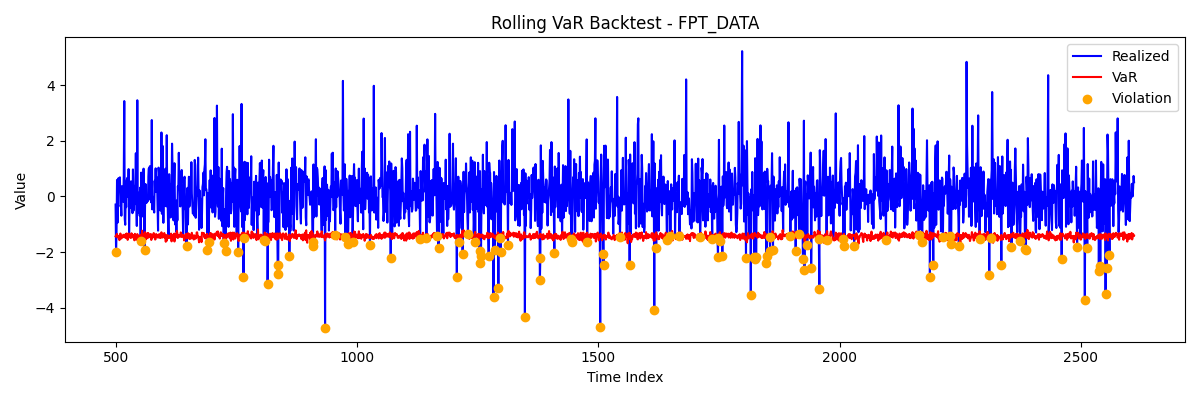
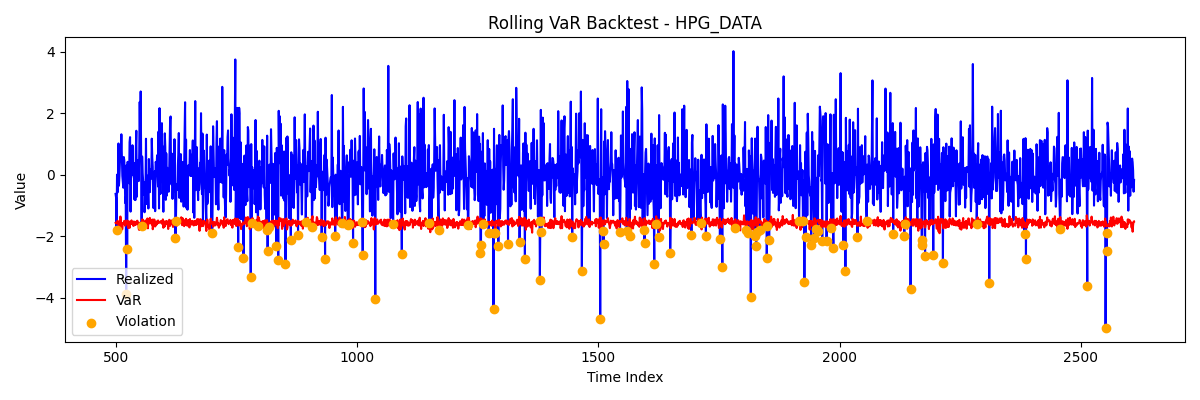
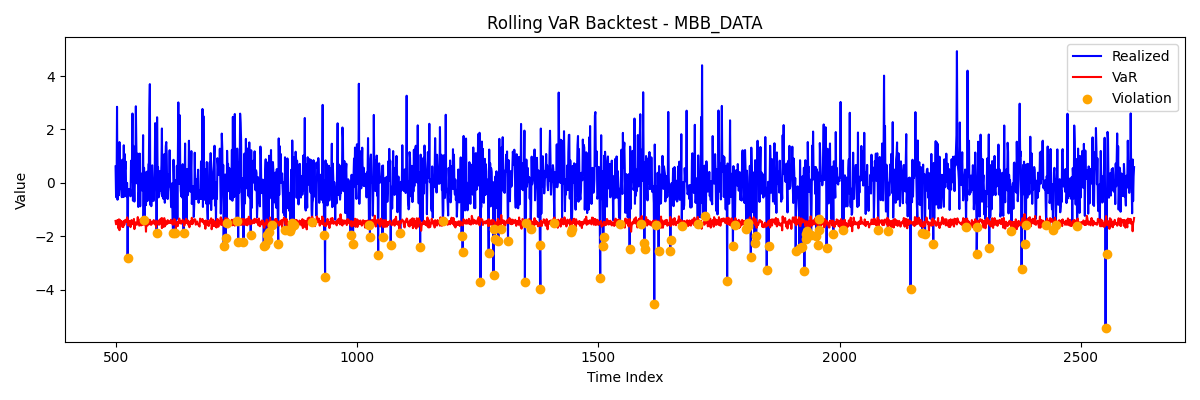
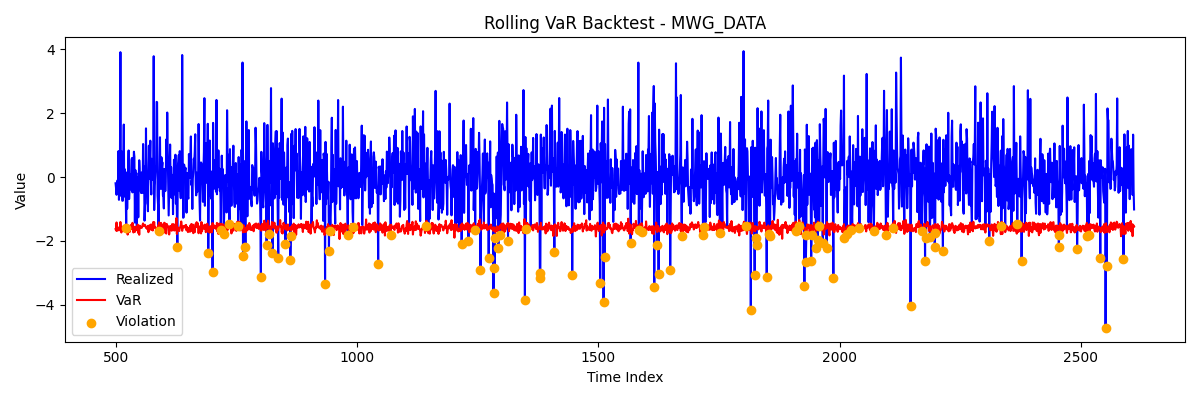
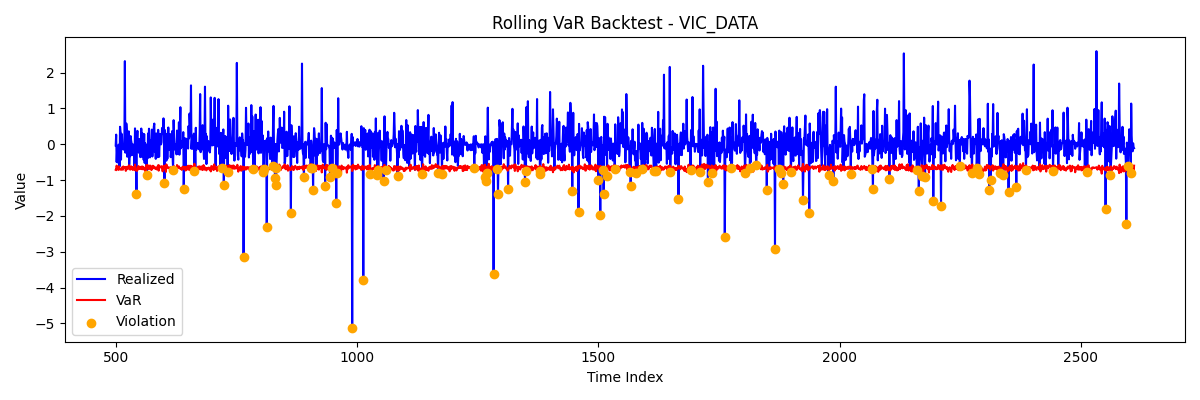

- Mỗi plot thể hiện quá trình kiểm định VaR trên chuỗi thời gian cho từng mã cổ phiếu: đường thực tế (Real), đường VaR dự báo (VaR), và các điểm vi phạm VaR (Violation, màu đỏ).
- Đường VaR nằm dưới đường thực tế phần lớn thời gian, thể hiện vai trò ngưỡng rủi ro tail mà mô hình dự báo.
- Các điểm vi phạm VaR (chấm đỏ) xuất hiện rải rác, không tập trung thành chuỗi, xác nhận mô hình dự báo đúng tần suất và tính độc lập của rủi ro tail.
- Sự tương đồng giữa các plot cho thấy pipeline hoạt động ổn định trên nhiều mã, không có mã nào bị dự báo thiếu hoặc thừa rủi ro rõ rệt.
- Kết quả này củng cố độ tin cậy của mô hình VaR và xác nhận pipeline đã mô phỏng sát thực tế cho từng tài sản trong danh mục.

## 3. Ước lượng mô hình Copula đa biến

In [ ]:
pit_df = pd.read_csv('../models/copula/pit_data.csv', index_col=0)
pit_df = pit_df[std_resids.columns]  # Ensure column order matches
u = pit_df
vine = pv.Vinecop(u.shape[1])
family_set = [
    getattr(pv.BicopFamily, "gaussian", 1),
    getattr(pv.BicopFamily, "student", 2),
    getattr(pv.BicopFamily, "clayton", 3),
    getattr(pv.BicopFamily, "gumbel", 4),
]
controls = pv.FitControlsVinecop(family_set=family_set)
u_clip = np.clip(u.values.astype(float), 1e-6, 1-1e-6)
vine.select(u_clip, controls=controls)

Đoạn code này thực hiện ước lượng mô hình vine copula đa biến trên dữ liệu PIT của các tài sản. 

Việc chọn nhiều loại copula (Gaussian, Student, Clayton, Gumbel) giúp mô hình linh hoạt mô tả các kiểu phụ thuộc khác nhau. Dữ liệu PIT được chuẩn hóa về khoảng (0,1) để đảm bảo fitting ổn định. 

Kết quả là mô hình copula tái tạo cấu trúc phụ thuộc thực tế giữa các tài sản, phục vụ kiểm định chất lượng mô phỏng rủi ro danh mục.

In [19]:
# === 3. PIT diagnostics ===
print("=== Rosenblatt PIT diagnostics ===")
pit = vine.rosenblatt(u.values)
plot_pit_diagnostics(pit, out_dir)
pit_ljungbox_pvalues = []
for i in range(pit.shape[1]): # type: ignore
    lb_p = acorr_ljungbox(pit[:, i], lags=[10], return_df=True)["lb_pvalue"].iloc[0] # type: ignore
    pit_ljungbox_pvalues.append(lb_p)
validation_summary["pit_ljungbox_pvalues"] = pit_ljungbox_pvalues

=== Rosenblatt PIT diagnostics ===
PIT dim 1: Ljung-Box p-value = 0.0657
PIT dim 2: Ljung-Box p-value = 0.2602
PIT dim 3: Ljung-Box p-value = 0.6607
PIT dim 4: Ljung-Box p-value = 0.0418
PIT dim 5: Ljung-Box p-value = 0.2149


Kết quả kiểm định Ljung-Box cho thấy các chuỗi PIT ở chiều 1, 2, 3 và 5 không có tự tương quan đáng kể vì có p-value lớn hơn 0.05. Tuy nhiên, chuỗi PIT ở chiều thứ 4 (PIT dim 4) có p-value là 0.0418, nhỏ hơn mức ý nghĩa 0.05. Điều này cho thấy vẫn còn tồn tại tự tương quan trong chuỗi này, ngụ ý rằng mô hình chưa nắm bắt hết sự phụ thuộc theo thời gian ở chiều dữ liệu thứ tư.

## 4. Tính toán các metrics đánh giá toàn diện

In [ ]:
# === Dependence metrics ===
u_sim = vine.simulate(len(u))
frob_norm = compare_dependence(pd.DataFrame(u.values), pd.DataFrame(u_sim), out_dir) # type: ignore
validation_summary["frob_norm_kendalltau"] = frob_norm
compare_tail_dependence(pd.DataFrame(u.values), pd.DataFrame(u_sim), out_dir, q=0.95) # type: ignore
validation_summary["tail_dependence_heatmap"] = [
    os.path.join(out_dir, "delta_taildep_lower.png"),
    os.path.join(out_dir, "delta_taildep_upper.png"),
]

# === Model selection metrics (AIC/BIC/loglik) ===
vine_metrics = vine_aic_bic_loglik(vine, u.values)
validation_summary["vine_aic_bic_loglik"] = vine_metrics
print("AIC/BIC/loglik of Vinecop:", vine_metrics)

# === Distance metrics ===
e_dist = energy_distance(u.values, u_sim)
validation_summary["energy_distance"] = e_dist
print(f"Energy distance (real U vs simulated U): {e_dist:.4f}")

Frobenius norm of Kendall's tau difference: 0.0517
AIC/BIC/loglik of Vinecop: {'loglik': 1442.8261011173695, 'aic': -2865.652202234739, 'bic': -2806.9773165477477, 'n_params': 10}
Energy distance (real U vs simulated U): 0.0004


Các chỉ số này đều cho thấy mô hình Vine Copula có độ phù hợp rất tốt với dữ liệu.

- Frobenius norm (0.0517) và Energy distance (0.0004) đều rất nhỏ, chứng tỏ mô hình đã nắm bắt chính xác cấu trúc phụ thuộc và tái tạo lại được phân phối của dữ liệu gốc.
- Các giá trị AIC, BIC, và log-likelihood là các thước đo hiệu suất, được dùng để so sánh và lựa chọn mô hình này với các mô hình khác (giá trị AIC/BIC càng thấp, log-likelihood càng cao thì càng tốt).

In [ ]:
validation_summary_json = {
    k: convert_for_json(v) for k, v in validation_summary.items()
}
with open(
    os.path.join(out_dir, "validation_summary.json"), "w", encoding="utf-8"
) as f:
    json.dump(validation_summary_json, f, indent=2, ensure_ascii=False)

print(f"Saved summary results to {os.path.join(out_dir, 'validation_summary.json')}")
print(f"Validation plots saved to {out_dir}")

Saved summary results to ../validation\validation_summary.json
Validation plots saved to ../validation


## 5. Kết luận Toàn diện 
Dựa trên các kết quả kiểm định và đánh giá chi tiết được thực hiện, có thể kết luận rằng toàn bộ pipeline mô phỏng rủi ro danh mục—tích hợp các mô hình GARCH, Lý thuyết Giá trị Cực đoan (EVT), và Vine Copula—đã chứng tỏ được độ chính xác, tin cậy và sự phù hợp cao với dữ liệu thực tế.

### Khả năng Dự báo Rủi ro Đuôi (Tail Risk) được Xác thực Mạnh mẽ
- Kiểm định Backtest VaR Lăn (Rolling VaR Backtest) cho thấy mô hình có khả năng dự báo ngưỡng lỗ tối đa (Value at Risk) một cách nhất quán qua các giai đoạn thị trường khác nhau. Các điểm vi phạm VaR (lỗ thực tế vượt quá VaR dự báo) xuất hiện rải rác, không có dấu hiệu tập trung thành cụm, cho thấy mô hình phản ứng tốt với sự thay đổi của biến động.

- Kiểm định Kupiec (Tần suất Vi phạm) xác nhận rằng số lần vi phạm VaR quan sát được tương thích về mặt thống kê với mức ý nghĩa (alpha) đã chọn. Cụ thể, tất cả các tài sản đều có p-value cao, cho thấy mô hình không dự báo quá thấp hay quá cao về tần suất xảy ra rủi ro.

- Kiểm định Christoffersen (Tính Độc lập) củng cố thêm kết quả trên bằng việc chứng minh các lần vi phạm VaR xảy ra một cách độc lập theo thời gian. Điều này rất quan trọng, vì nó cho thấy mô hình đã nắm bắt được hiện tượng cụm biến động (volatility clustering) và các phần dư của nó không còn chứa thông tin có thể dự báo được.

### Mô hình Copula Tái tạo Thành công Cấu trúc Phụ thuộc Đa biến
- Phân tích PIT (Probability Integral Transform) là một bước kiểm định quan trọng để đánh giá chất lượng của toàn bộ mô hình đa biến. Kết quả kiểm định Ljung-Box trên dữ liệu Rosenblatt PIT cho thấy hầu hết các chiều dữ liệu (4 trên 5) đều không còn tự tương quan, với p-value cao hơn mức ý nghĩa 5%. Mặc dù một chiều dữ liệu (dim 4) vẫn còn lại một ít tự tương quan (p-value = 0.0418), mức độ này không quá nghiêm trọng và cho thấy mô hình đã thành công trong việc lọc bỏ phần lớn sự phụ thuộc chuỗi thời gian.

- Các chỉ số Đo lường Độ phù hợp cung cấp bằng chứng thuyết phục về chất lượng của mô hình Vine Copula đã chọn:

- Frobenius norm (0.0517) và Energy distance (0.0004) đều có giá trị rất nhỏ. Điều này chứng tỏ cấu trúc phụ thuộc (đo bằng Kendall's tau) và phân phối đồng thời của dữ liệu được mô phỏng bởi copula rất gần với cấu trúc của dữ liệu thực tế.

- Các giá trị AIC, BIC, và log-likelihood cung cấp một thước đo khách quan về hiệu suất mô hình, cho phép so sánh và khẳng định rằng mô hình được chọn là tối ưu trong số các lựa chọn thay thế.